## Метод k-ближайших соседей и метрики качества классификации
Пензин М.С.

penzin.ml.tsu@gmail.com

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

## Метод k-ближайших соседей

Вторым из самых простых алгоритмов машинного обучения является метод k-ближайших соседей. Его основная идея заключается в том, что если какой-то объект близок по какому-нибудь критерию к другим объектам, то вероятно он также относится к категории этих объектов.

## Как это работает?

Пусть у нас есть множество прецедентов $\mathbf{X}$ и набор целевых исходов/меток $\vec{Y}$.

Определим функцию растояния между прецедентами, такую, что:

$$
d(\vec{x}_1, \vec{x}_2) > 0, \text{ при } \vec{x}_1 \ne \vec{x}_2 \\
d(\vec{x}_1, \vec{x}_2) = 0, \text{ при } \vec{x}_1 = \vec{x}_2 \\
d(\vec{x}_1, \vec{x}_2) = d(\vec{x}_2, \vec{x}_1) \\
d(\vec{x}_1, \vec{x}_3) \le d(\vec{x}_1, \vec{x}_2) + d(\vec{x}_2, \vec{x}_3)
$$

Пусть у нас есть прецедент $\vec{x}$ и нам нужно определить, к какому классу относится данный прецендент.

Мы просто находим расстояние от $\vec{x}$ до всех прецедентов в обучающей выборке $\mathbf{X}$. Потом просто берем $k$ прецедентов с наименьшим расстоянием до $\vec{x}$ и устраиваем голосование.

In [25]:
y1 = np.random.normal((2, 2), size=(100, 2))
y2 = np.random.normal((-2, 2), size=(100, 2))
y3 = np.random.normal((0, -3), size=(100, 2))
data = np.vstack([y1, y2, y3])
target = np.hstack([
    np.full(y1.shape[0], 0), 
    np.full(y2.shape[0], 1), 
    np.full(y3.shape[0], 2),
])

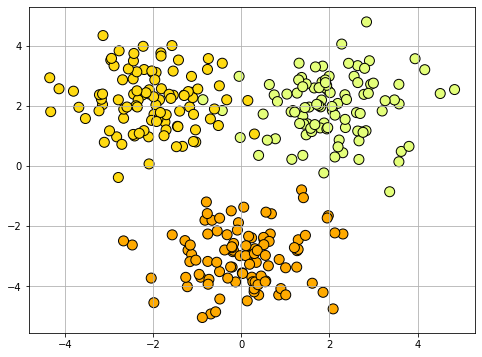

In [26]:
plt.scatter(data[:, 0], data[:, 1], c=target, 
            cmap=plt.get_cmap("Wistia"), edgecolors='k', s=100, 
            vmin=0, vmax=3)
plt.grid()
plt.show()

In [7]:
def plot_scatter(cls, data, target, outer=0.1, **kargs):
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    x_w = x_max - x_min
    y_min, y_max = data[:, 1].min(), data[:, 1].max()
    y_w = y_max - y_min
    xx, yy = np.meshgrid(
        np.arange(x_min - x_w * outer, x_max + x_w * outer, 0.05),
        np.arange(y_min - y_w * outer, x_max + y_w * outer, 0.05),
    )

    model = cls(**kargs)
    model.fit(data, target)
    predict = model.predict(np.stack([xx.ravel(), yy.ravel()], axis=1))
    plt.pcolormesh(xx, yy, predict.reshape(xx.shape), cmap=plt.get_cmap("Wistia"))
    plt.scatter(data[:, 0], data[:, 1], c=target, 
                cmap=plt.get_cmap("Wistia"),
                edgecolors='k', s=50, vmin=0, vmax=1);
    plt.show()

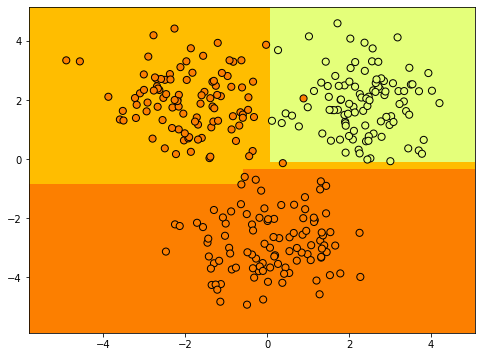

In [8]:
from sklearn.tree import DecisionTreeClassifier
plot_scatter(DecisionTreeClassifier, data, target, 
             max_depth=3)

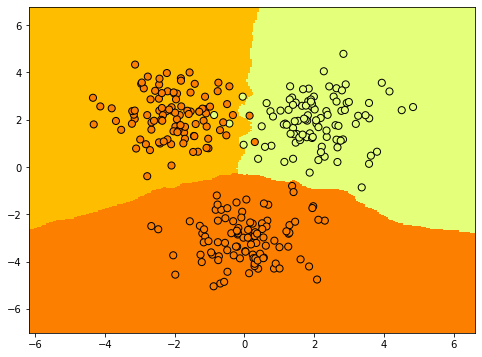

In [28]:
from sklearn.neighbors import KNeighborsClassifier
plot_scatter(KNeighborsClassifier, data, target, 0.2,
             n_neighbors=10)

## А что c регрессией?

В задачах регрессии, значение для прецедента $\vec{x}$ - это просто среднее значение всех его соседей.

In [30]:
from sklearn.neighbors import KNeighborsRegressor

train = np.linspace(0, 5, 20)
target = np.sin(train) + np.random.normal(0, 0.1, train.shape)

def knn_reg(**karg):
    knn = KNeighborsRegressor(**karg)
    knn.fit(train.reshape(-1, 1), target)
    x = np.linspace(-2, 7, 500)
    pred = knn.predict(x.reshape(-1, 1))
    plt.plot(train, target, "ko")
    plt.plot(x, pred, 'r-')
    plt.show()

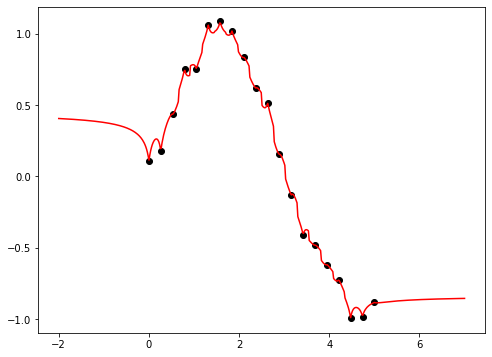

In [31]:
#knn_reg(n_neighbors=5, weights='uniform')
knn_reg(n_neighbors=5, weights='distance')

# Кластеризация (K-means)

Данный подход с незначительными изменениями можно использовать для кластеризации.

Для этого нужно задать предполагаемое число кластеров $k$, затем берется случайных $k$-точек, которые будут считаться центрами наших кластеров.

Затем
1. Для каждого объекта присваивается номер класса, к центру которого он ближе всего
2. Вычисляется центр масс класстера, который становится новым центром кластер (среднее арифметическое соответствующих координат)
3. Перейти к шагу 1.

Это является частным случаем [EM-алгоритма](https://ru.wikipedia.org/wiki/EM-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC).

<img style="max-height: 100%" src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif">

## Растояние

Как выбрать метрику расстояния между прецендентами?

Самое очевидно, но не всегда правильное, это использовать евклидову метрику

$$
d(\vec{x}_1, \vec{x}_2) = \sqrt{
    \sum_i (x_{1i} - x_{2i})^2
}
$$

Есть множество различных метрик, наилучшую можно найти с помощью кросс-валидации

* Манхэттенское расстояние - $d(\vec{x}_1, \vec{x}_2) = \sum_i |x_{1i} - x_{2i}|$
* Расстояние Чебышева  - $d(\vec{x}_1, \vec{x}_2) = \max_i |x_{1i} - x_{2i}|$
* Расстояние Минковского - $d(\vec{x}_1, \vec{x}_2) = \sqrt[1/p]{
    \sum_i (x_{1i} - x_{2i})^p
}$
* Косинусное расстояние - $\frac{\vec{x}_1 \vec{x}_2}{\| \vec{x}_1 \| \vec{x}_2 \|}$

## Подготовка данных

Что если один признак у нас принимает значения порядка $10^5$, а второй признак порядка $10$? Как это повлияет на определение расстояния?

Данные необходимо подготавливать

## Минимакс

Один из самых простых подходов - это минимаксная нормализация

$$
x^* = \frac{x - \min X}{\max{X} - \min{X}}
$$

Это просто переводит значение признака на интервал $[0, 1]$

## Стандартизация

Альтернативный подход - это масштабирование данных с помощью среднего значения и дисперсии
$$
x^* = \frac{x - \bar{x}}{\sigma_x}
$$

## Голосование

Голосование за результирующий класс может быть

* невзвешенным (uniform) $v = \sum_n 1$
* взвешенным (distance) $v = \sum_n \frac{1}{d^2(\vec{x}, \vec{x}_n)}$



## Растяжение осей

В случае наличия априорных сведения или банальной интуции, может стать известно, что один признак важнее другого признака. В этом случае мы можем ввести значимость признаков. Например, для евклидовой метрики этом примет вид

$$
d(\vec{x}_1, \vec{x}_2) = \sqrt{
    \sum_i C_i(x_{1i} - x_{2i})^2
}
$$

## Большие объемы данных

При больших объемах данных, вычисления уже начинают занимать существенное время.

* фильтрация обучающей выборки
* эффективная модель хранения данных

## sklearn

В sklearn данным метод представлен двумя классами **KNeighborsClassifier** и __KNeighborsRegressor__.

## Гиперпараметры

* *n_neighbours* - число соседей
* *metric* - метрика расстояния между прецендентами
* *weight* - веса

## Плюсы

* хорошо изучен
* прост и понятен для интерпретации
* хороший старт для решения задач
* удобно использовать для построения мета-признаков или композиции алгоритмов
* применим в широком спектре задач


## Минусы

* проклятие размерностей, при большом числе признаков, преценденты в среднем оказываются рядом со всеми
* при больших выборках начинает медлено работать, можно исправить убиранием ненужных прецендентов, оптимальным представлением данных.
* сложность подбора метрики расстояния
* при небольшом числе соседей чувствителен к выбросам

## Метрики оценки качества классификации

Мы уже знакомы с метрикой *accuracy_score* (доля правильных ответов), которая просто показывает процент правильных ответов. В самом общем случае, она не всегда дает приемлемые результаты. Особенно это заметно в задачах с неравными классами.

**Например:** Пусть у нас есть 100 хороших писем и 10 спам-писем. 
Наш классификатор определил правильно 90 хороших и 5 спам-писем.

$$
m = \frac{90 + 5}{100 + 10} \approx 0.86
$$

Но если мы просто будем говорить, что все письма не спам

$$
m = \frac{100 + 0}{100 + 10} \approx 0.91
$$

## Матрица неточностей

In [14]:
from sklearn.metrics import confusion_matrix
df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
from sklearn.naive_bayes import GaussianNB

data = df[(df["age"] > 12500)&
          (df["weight"] > 40)&(df["weight"] < 105)&
          (df["height"] > 140)&(df["height"] < 190)&
          (df["ap_lo"] > 60)&(df["ap_lo"] < 110)&
          (df["ap_hi"] > 80)&(df["ap_hi"] < 170)]
train = data[["age", "weight", "height", "ap_lo", "ap_hi"]]
target = data['cardio']

gnb = GaussianNB()
gnb.fit(train, target)
predict_proba = gnb.predict_proba(train)
predict = gnb.predict(train)
cnf_matrix = confusion_matrix(target, predict)

In [15]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

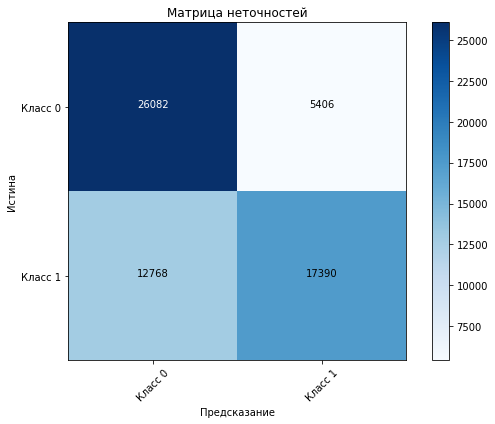

In [16]:
plot_confusion_matrix(cnf_matrix, ["Класс 0", "Класс 1"])

* _True Positive(TP)_  - истинно-положительный
* _False Positive(FP)_  - ложно-положительный
* _True Negative(TN)_  - истинно-отрицательный
* _False Negative(FN)_  - ложно-отрицательный

|          | Класс 0 | Класс 1 |
|----------|---------|---------|
| Класс 0  | TP      | FN      |
| Класс 1  | FP      | TN      |

Доля правильных ответов тогда

$$
accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

Точность (доля правильных ответов среди ответов с этим классом)

$$
precision = \frac{TP}{TP + FP}
$$

Полнота (доля правильно найденных объектов данного класса)

$$
recall = \frac{TP}{TP + FN}
$$

Данные метрики работают в случае несбалансированности классов.

## F-мера

Есть несколько способов объединения точности и полноты в единое значение. Например, т.н. F-мера (среднее гармоническое)

$$
F_\beta = (1+\beta^2) \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}
$$

Если вернуться к примеру со спам-письмами

|          | Cпам    | Не спам |
|----------|---------|---------|
| Спам     | 5       | 5       |
| Не спам  | 10      | 90      |


|          | Cпам    | Не спам |
|----------|---------|---------|
| Спам     | 0       | 10      |
| Не спам  | 0       | 100     |


Для первого классификатора получим:

$$
accuracy \approx 0.86
\\
precision \approx 0.33
\\
recall = 0.5
\\
F_1 \approx 0.398
$$

Для второго (наивного) классификатора

$$
accuracy \approx 0.91
\\
precision \approx 0
\\
recall = 0
\\
F_1 \approx 0
$$

In [17]:
from sklearn.metrics import classification_report

report = classification_report(target, predict, target_names=["Здоров", "Болен"])
print(report)

              precision    recall  f1-score   support

      Здоров       0.67      0.83      0.74     31488
       Болен       0.76      0.58      0.66     30158

    accuracy                           0.71     61646
   macro avg       0.72      0.70      0.70     61646
weighted avg       0.72      0.71      0.70     61646



## ROC AUC

При определении принадлежности прецедента к какому-нибудь классу в случае бинарной классификации, мы должны выбрать порог вероятности, с которого мы будет считать, что данный прецендент относится к этому классу. 


Естественным является порог 0.5, но он не всегда оптимальный. Это наиболее важно при отсутствии баланса между классами.

**ROC AUC** - это площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve). 

**Кривая ошибок** - это линия от (0,0) до (1,1) в координатах True Positive Rate(TPR) и False Positive Rate(FRP) при изменении порога 

$$
    TPR = \frac{TP}{TP + FN} \\
    FPR = \frac{FP}{FP + TN}
$$

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(target, predict_proba[:,1], pos_label=1)

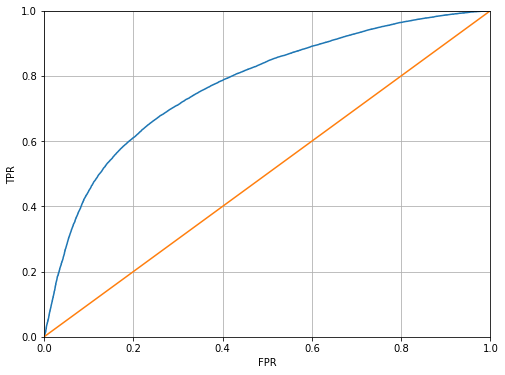

In [19]:
plt.xlim([0, 1]); plt.xlabel("FPR")
plt.ylim([0, 1]); plt.ylabel("TPR")
plt.plot(fpr, tpr); plt.plot([0, 1], [0, 1])
plt.grid(); plt.show()

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target, predict_proba[:,1])

0.7727825762341707

Можно также построить кривую Precision-Recall и оценивать площадь под этой кривой (PR AUC).

In [22]:
from sklearn.metrics import precision_recall_curve
pr, rc, thr = precision_recall_curve(target, predict_proba[:,1], pos_label=1)

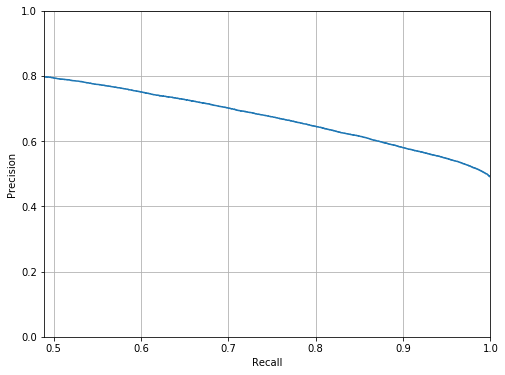

In [23]:
plt.xlim([pr.min(), pr.max()]); plt.xlabel("Recall")
plt.ylim([rc.min(), rc.max()]); plt.ylabel("Precision")
plt.plot(rc, pr); plt.grid(); plt.show()

## Логистическая функция потерь

одна из самых популярных метрик в соревнованиях.

$$
L = - (y_i \log p_i + (1-y_i) \log (1 - p_i))
$$
где $p_i$ - это ответ классификатора для класса 0, $t_i$ - это истинное значение

К особенности логистической функции потерь можно отнести очень сильный штраф за уверенность классификатора в правильности неправильного ответа.

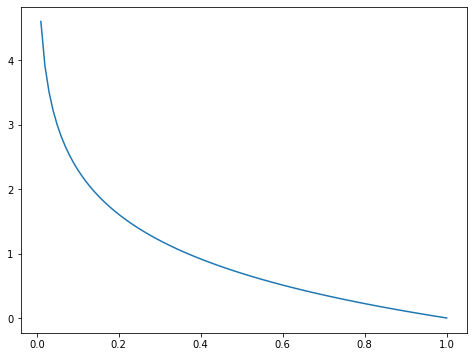

In [27]:
x = np.linspace(0.01, 1, 100)
plt.plot(x, -np.log(x));

In [76]:
-np.log(0.5)

0.6931471805599453

In [77]:
-np.log(0.9)

0.10536051565782628

In [78]:
-np.log(0.1)

2.3025850929940455